Setup environment

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib

In [29]:
# Setup Style Visualisasi agar Bagus
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11, 'figure.dpi': 100})

# ==========================================
# 1. LOAD DATASET & PROFILE DATASET
# ==========================================

In [30]:
# Membaca dataset
df = pd.read_csv('online_shoppers_intention.csv')

print(f"Shape Awal: {df.shape}")
print(df.info())

Shape Awal: (12330, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14

# ==========================================
# 2. DATA PREPROCESSING (PERBAIKAN ERROR)
# ==========================================

In [31]:
# 2.1 Handling Missing Values & Duplicates
# Menghapus baris duplikat
duplicates = df.duplicated().sum()
print(f"Jumlah data duplikat yang dihapus: {duplicates}")
df_clean = df.drop_duplicates()

# Menghapus Missing Value (jika ada)
df_clean = df_clean.dropna()

Jumlah data duplikat yang dihapus: 125


In [32]:
# 2.2 Encoding Variabel Kategorikal (PERBAIKAN LOGIKA)
# Mapping Month (Agar urutannya benar secara kalender, bukan abjad)
month_map = {
    'Feb': 2, 'Mar': 3, 'May': 5, 'June': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10,
    'Nov': 11, 'Dec': 12
}
df_clean['Month'] = df_clean['Month'].map(month_map)

# Encoding Kategorikal
le_visitor = LabelEncoder()
df_clean['VisitorType'] = le_visitor.fit_transform(df_clean['VisitorType'])
df_clean['Weekend'] = df_clean['Weekend'].astype(int)
df_clean['Revenue'] = df_clean['Revenue'].astype(int)

# Hapus Multikolinieritas
if 'BounceRates' in df_clean.columns:
    df_clean = df_clean.drop('BounceRates', axis=1)

print("✅ Preprocessing Selesai.")
print(df_clean.dtypes)

✅ Preprocessing Selesai.
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                        int64
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                  int64
Weekend                      int64
Revenue                      int64
dtype: object


# ==========================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================

/tmp/ipython-input-2946088426.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Revenue', data=df_clean, palette='pastel')


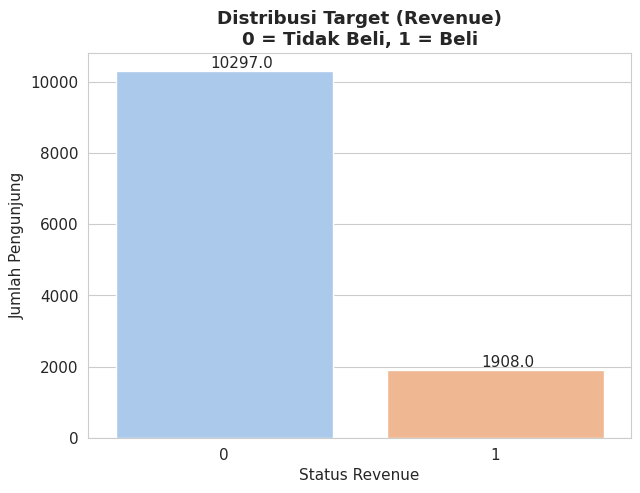

In [39]:
# 1. Plot Distribusi Target (Revenue)
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='Revenue', data=df_clean, palette='pastel')
plt.title('Distribusi Target (Revenue)\n0 = Tidak Beli, 1 = Beli', fontweight='bold')
plt.xlabel('Status Revenue')
plt.ylabel('Jumlah Pengunjung')

# Menambahkan label angka di atas batang
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 100))

plt.savefig('1_distribusi_target.png', bbox_inches='tight') # Simpan Gambar
plt.show()

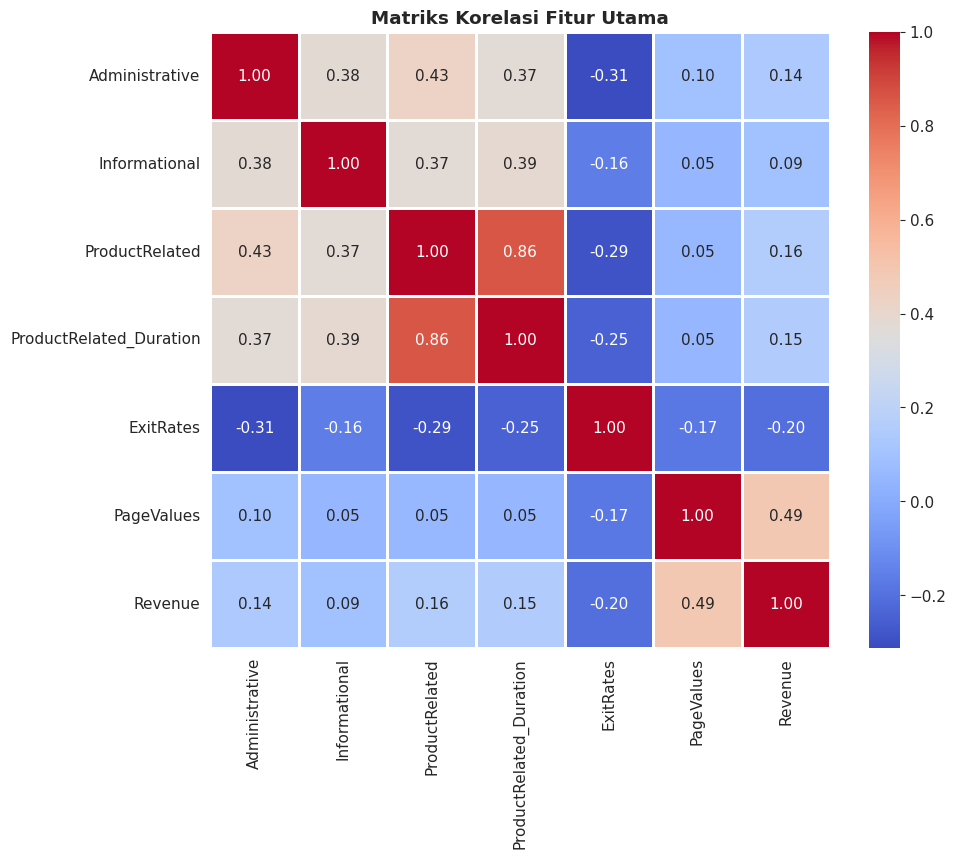

In [40]:
# 2. Plot Matriks Korelasi (Fitur Utama)
cols_corr = ['Administrative', 'Informational', 'ProductRelated',
             'ProductRelated_Duration', 'ExitRates', 'PageValues', 'Revenue']

plt.figure(figsize=(10, 8))
sns.heatmap(df_clean[cols_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)
plt.title('Matriks Korelasi Fitur Utama', fontweight='bold')
plt.savefig('2_korelasi_heatmap.png', bbox_inches='tight') # Simpan Gambar
plt.show()

# ==========================================
# 4. SELEKSI FITUR & SPLITTING
# ==========================================

In [35]:
X = df_clean.drop('Revenue', axis=1)
y = df_clean['Revenue']

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling (Opsional untuk Random Forest, tapi bagus untuk stabilitas)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 5. MODELING AWAL (BASE MODEL)
# ==========================================

--- 5. MODELING (Sebelum Smote) ---


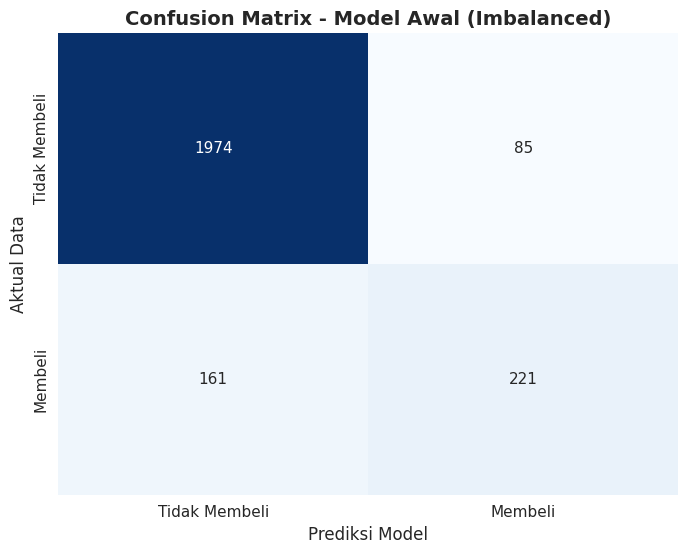

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2059
           1       0.72      0.58      0.64       382

    accuracy                           0.90      2441
   macro avg       0.82      0.77      0.79      2441
weighted avg       0.89      0.90      0.89      2441



In [42]:
print("--- 5. MODELING (Sebelum Smote) ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# FUNGSI UNTUK PLOT CONFUSION MATRIX
def plot_cm(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Tidak Membeli', 'Membeli'],
                yticklabels=['Tidak Membeli', 'Membeli'])
    plt.xlabel('Prediksi Model', fontsize=12)
    plt.ylabel('Aktual Data', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.savefig(filename)
    plt.show()

# Plot 3: CM Sebelum Perbaikan
plot_cm(y_test, y_pred,
        'Confusion Matrix - Model Awal (Imbalanced)',
        '3_cm_before_smote.png')

print(classification_report(y_test, y_pred))

# ==========================================
# 6. IMPLEMENTASI SMOTE & EVALUASI (AFTER)
# ==========================================


--- 6. EVALUASI BASE MODEL ---
Menerapkan SMOTE...
=== LAPORAN EVALUASI MODEL SETELAH SMOTE (AFTER) ===
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2059
           1       0.62      0.71      0.66       382

    accuracy                           0.89      2441
   macro avg       0.78      0.82      0.80      2441
weighted avg       0.89      0.89      0.89      2441



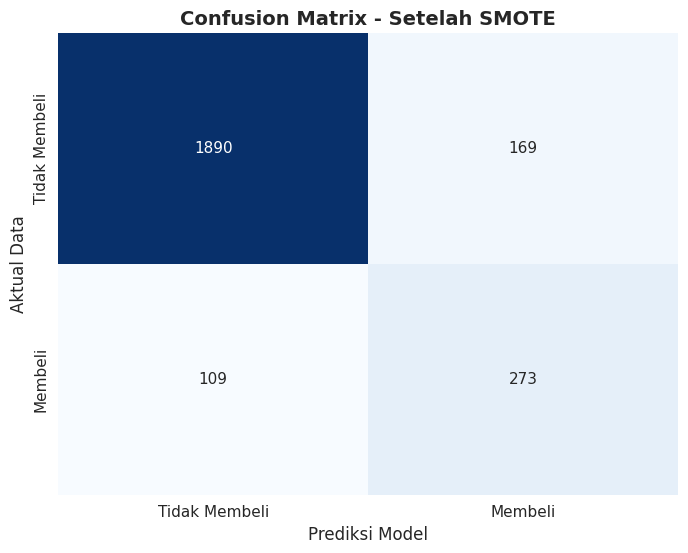

In [44]:
print("\n--- 6. EVALUASI BASE MODEL ---")
# Penerapan SMOTE
print("Menerapkan SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Train Ulang Model dengan Data Balanced
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test_scaled)

# Tampilkan Hasil
print("=== LAPORAN EVALUASI MODEL SETELAH SMOTE (AFTER) ===")
print(classification_report(y_test, y_pred_smote))
plot_cm(y_test, y_pred_smote, 'Confusion Matrix - Setelah SMOTE', '4_cm_smote.png')


# ==========================================
# 7. FEATURE IMPORTANCE (UNTUK BAB ANALISA)
# ==========================================

/tmp/ipython-input-1017941857.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')


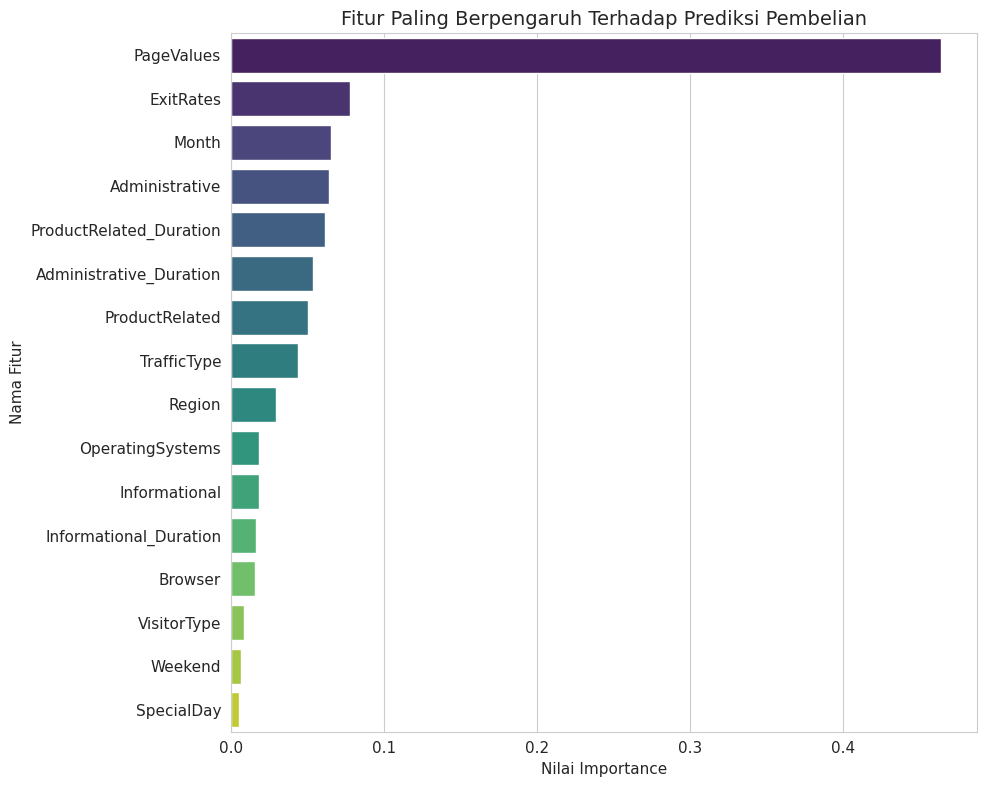

In [38]:
# Mengambil tingkat kepentingan fitur dari model Random Forest
importances = rf_smote.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1] # Urutkan dari terbesar

plt.figure(figsize=(10, 8))
sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')
plt.title('Fitur Paling Berpengaruh Terhadap Prediksi Pembelian', fontsize=14)
plt.xlabel('Nilai Importance')
plt.ylabel('Nama Fitur')
plt.tight_layout()
plt.savefig('5_feature_importance.png')
plt.show()

In [48]:
model_data = {
    'model': rf_smote,
    'scaler': scaler,
    'le_visitor': le_visitor,
    'features': X.columns.tolist()
}

filename = 'model.pkl'
joblib.dump(model_data, filename)

['model.pkl']

In [51]:
import pandas as pd

file_path = '/content/model.pkl' # Replace with your file's path

try:
    df = pd.read_pickle(file_path)
    print("DataFrame loaded successfully:")
    print(df.head()) # Print the first few rows of the DataFrame
except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: invalid load key, '\x03'.
